In [1]:
import torch
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.data import NeighborSampler
#from torch.optim.lr_scheduler import ReduceLROnPlateau

from modules.model import Net
from modules.sampling import RWSampler

from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

In [2]:
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)


sampler = RWSampler(data,data.train_mask,device)

In [3]:
loader = sampler.loader()

In [4]:
model = Net(dataset = dataset,mode='unsupervised',conv='SAGE')
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = ReduceLROnPlateau(optimizer, 'min') 

In [5]:
train_loader = NeighborSampler(data.edge_index, batch_size = 1078, node_idx=data.train_mask, sizes=[25, 10],
                               shuffle=True)
def train(model,data,optimizer,loader):
    model.train()        
    
    total_loss = 0
    for _, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        out = model.forward(data.x[n_id].to(device), adjs)
        optimizer.zero_grad()
        for i, (pos_rw, neg_rw) in enumerate(loader):
            loss = model.loss(out, pos_rw.to(device), neg_rw.to(device))
            total_loss+=loss
    total_loss.backward(retain_graph=True)
    optimizer.step()      
    return total_loss /len(loader)


@torch.no_grad()
def test(model,data):
    model.eval()
    out = model.inference(data.x,data)
    y_true = y.cpu().detach().numpy()
    clf = MLPClassifier(random_state=1, max_iter=2000).fit(out.cpu().detach().numpy(),y_true)
    y_pred = clf.predict(out.cpu().detach().numpy())
    #cm = confusion_matrix(y_true,y_pred)
    results = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:    
        results += [(clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy()))]
        
    return results

In [6]:
losses=[]
train_accs =[]
val_accs =[]
test_accs=[]

for epoch in range(1, 25):
    loss = train(model,data,optimizer,loader)
    losses.append(loss)
    train_acc, val_acc, test_acc = test(model,data)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    val_accs.append(val_acc)
    #scheduler.step(loss)
    log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(loss, epoch, train_acc, val_acc, test_acc))

Loss: 1.3934, Epoch: 001, Train: 0.6786, Val: 0.6920, Test: 0.6830
Loss: 1.3894, Epoch: 002, Train: 0.7786, Val: 0.7180, Test: 0.7290
Loss: 1.3865, Epoch: 003, Train: 0.7929, Val: 0.7300, Test: 0.7370
Loss: 1.3838, Epoch: 004, Train: 0.8000, Val: 0.7500, Test: 0.7630
Loss: 1.3824, Epoch: 005, Train: 0.8071, Val: 0.7660, Test: 0.7590
Loss: 1.3812, Epoch: 006, Train: 0.8286, Val: 0.7780, Test: 0.7780
Loss: 1.3794, Epoch: 007, Train: 0.8357, Val: 0.7700, Test: 0.7850
Loss: 1.3783, Epoch: 008, Train: 0.8286, Val: 0.7980, Test: 0.8090
Loss: 1.3769, Epoch: 009, Train: 0.8286, Val: 0.7980, Test: 0.8130
Loss: 1.3757, Epoch: 010, Train: 0.8286, Val: 0.7900, Test: 0.8100
Loss: 1.3744, Epoch: 011, Train: 0.8357, Val: 0.7860, Test: 0.8040
Loss: 1.3729, Epoch: 012, Train: 0.8214, Val: 0.7780, Test: 0.7960
Loss: 1.3707, Epoch: 013, Train: 0.8286, Val: 0.7820, Test: 0.8080
Loss: 1.3687, Epoch: 014, Train: 0.8286, Val: 0.7700, Test: 0.8010
Loss: 1.3691, Epoch: 015, Train: 0.8429, Val: 0.7720, Test: 0.

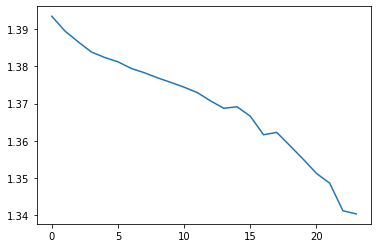

In [7]:
plt.plot(losses)

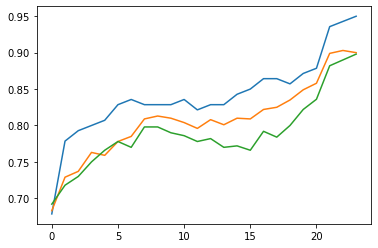

In [8]:
plt.plot(train_accs)
plt.plot(test_accs)
plt.plot(val_accs)